# Fig2 results - invitro dataset of cell line mix

We generated in vitro pools containing various ratios of HL60, SUDHL4, K562, and THP1 human leukemic cells, analyzed by standard bulk RNA sequencing. We could thus use these pre-determined ratios as ground truth to compare the predictive value of CLIMB (Fig. 2B) and a panel of bulk deconvolution methods: BayesPrism [16], CiberSortX [17], TAPE [18], Scaden [19], MUSIC [20], BisqueRNA [21], and NNLS [20], using random proportions as a negative control. We then assessed single-cell RNA expression of a mixture of cell lines, and used it as reference for all deconvolution methods with the same gene and cell selection.

In [14]:
library(ggplot2) ; library(glmnet) ; library(Biobase)
library(reshape2) ; library(ggpubr); library(SingleCellExperiment)
library(ComplexHeatmap) ; library(circlize) ; library(RColorBrewer)
library(cocor) ; library(ggpmisc)

# load Deconvolution Methods
library(MuSiC) ; library(climb) ; library(BayesPrism)

In [322]:
detach("package:climb", unload=TRUE)
devtools::install_github('alexdray86/climb', force=T)
library(climb)


── R CMD build ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/z6/0fzn0d4s1v74_s44tjrc9mg00000gp/T/Rtmpss3UBW/remotes8d2f2583c214/alexdray86-CLIMB-b8fcd03/DESCRIPTION’
─  preparing ‘climb’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘climb_0.0.5.tar.gz’
   



Attaching package: ‘climb’


The following objects are masked _by_ ‘.GlobalEnv’:

    bulk.es, sc.es




### Functions 

In [85]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){ return( sign(cor(pr,tr)) * cor(pr,tr)^2 ) }
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    # per row metrics:
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    # per-column metrics:
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    # overall metrics:
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){
    SStot = sum((tr - mean(tr))^2)
    SSres = sum((pr - tr)^2)
    return(1 - SSres / SStot)
}
r_square <- function(pr, tr){
    return( sign(cor(pr,tr))*cor(pr,tr)^2 )
}
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
} 
### Function for each deconvolution methods ### 
deconvolution_climb <- function(sc, bulks, true_prop, celltype_names){
    climb_res = climb(sc, bulks)
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_bayesprism <- function(sc, bulks, true_prop, celltype_names){
    myPrism <- new.prism(reference= t(exprs(sc)), 
                         mixture=t(exprs(bulks)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc$cellType), 
                         cell.state.labels = as.character(sc$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
    bp.res <- run.prism(prism = myPrism, n.cores=6)
    bayesprism_prop <- get.fraction (bp=bp.res, which.theta="final",
             state.or.type="type")
    bayesprism_prop = add_missing_celltypes(bayesprism_prop, celltype_names)
    return(as.matrix(bayesprism_prop[,celltype_names]))
}
deconvolution_music <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    music_prop = music.output$Est.prop.weighted
    music_prop = add_missing_celltypes(music_prop, celltype_names)
    return(music_prop[,celltype_names])
}
deconvolution_nnls <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    nnls_prop = music.output$Est.prop.allgene
    nnls_prop = add_missing_celltypes(nnls_prop, celltype_names)
    return(nnls_prop[,celltype_names])
}
deconvolution_bisque <- function(sc, bulks, true_prop, celltype_names){
    bisque.out = BisqueRNA::ReferenceBasedDecomposition(bulks, sc, use.overlap=F)
    bisque_prop = t(bisque.out$bulk.props)
    bisque_prop = add_missing_celltypes(bisque_prop, celltype_names)
    return(bisque_prop[,celltype_names])
}
deconvolution_random <- function(nnls_prop){
    nnls_prop = read.csv(paste0(out_dir, '/nnls_prop.csv'), row.names='X')
    set.seed(1)
    rand_prop = nnls_prop[sample(rownames(nnls_prop)), sample(colnames(nnls_prop))]
    rownames(rand_prop) = rownames(nnls_prop) ; colnames(rand_prop) = colnames(nnls_prop)
    return(rand_prop)
}
write_tables_cibersortx <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks.txt"), sep = '\t', quote=F)
    # Reformulate to add 'Gene' at the start of the file
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_pbulks.txt > ', 
    #              tab_dir, '/cibersortx_pbulks.txt'))
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_sc_mat.txt > ', 
    #              tab_dir, '/cibersortx_sc_mat.txt'))
    # remove temp files
    #system(paste0('rm ',tab_dir, '/TMP_*'))
}
write_tables_tape_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # Write all input tables formatted for TAPE / Scaden
    write.csv(t(exprs(bulks)), paste0(tab_dir, "/tape_scaden_bulks_expr.csv"), quote=F)
    sc_mat_TAPE = exprs(sc)
    sc_mat_TAPE = t(sc_mat_TAPE)
    rownames(sc_mat_TAPE) = sc$cellType
    write.csv(sc_mat_TAPE, paste0(tab_dir, "/tape_scaden_scmat_expr.csv"), quote=F)
}
deconvolution_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING: launching TAPE / Scaden from the command line induces figures popping up
    # which blocks the process (figures have to be closed manually). 
    # To prevent these figures to be made, one can comment lines 103-109,115-119,128-131, 
    # and 172-176 in the file 'tape_scaden_env/lib/python3.7/site-packages/TAPE/utils.py'
    message('Launch Scaden / TAPE deconvolution')
    # Launch bash script that will launch environment and python script
    system(paste0('bash launch_TAPE_and_Scaden.sh ', tab_dir, '/tape_scaden_scmat_expr.csv ',
                  tab_dir, '/tape_scaden_bulks_expr.csv ',
                  'data/GeneLength.txt ',
                  tab_dir, '/'), wait=TRUE)
}
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')[,as.character(celltype_names)]
    #climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')[,as.character(celltype_names)]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,as.character(celltype_names)]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,as.character(celltype_names)]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,as.character(celltype_names)]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,as.character(celltype_names)]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,as.character(celltype_names)]
    tape_p = load_tape_prop(tdir, odir, celltype_names)[,as.character(celltype_names)]
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)[,as.character(celltype_names)]
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='Mixture')[,as.character(celltype_names)]
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_prop) ; true_prop_rows = rownames(true_prop)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}                                                                                           
make_all_metrics <- function(all_ps, t_prop){
    all_rs = list()
    for(p in 1:length(all_ps)){
        name_p = names(all_ps)[p]
        all_rs[[name_p]] = suppressWarnings(comp_rows_and_cols(all_ps[[p]], t_prop))
    }
    names(all_rs) = names(all_ps)
    return(all_rs)
}
launch_all_deconvolution_methods <- function(sc, bulks, true_prop, celltype_names, out_dir){ 
    # Create folders
    message('Creating folders')
    tmp_dir = paste0(out_dir, '/tmp_tabs')
    dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)
    write.csv(true_prop, paste0(out_dir, '/true_prop.csv'), quote=F)
    write.csv(celltype_names, paste0(out_dir, '/celltype_names.csv'), quote=F)

    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, true_prop, celltype_names)
    write.csv(climb_prop, paste0(out_dir, '/climb_prop.csv'), quote=F)
    message(paste0('CLIMB Accruacy as PCC: ', cor(flatten(true_prop), flatten(climb_prop))))

    ### BayesPrism deconvolution ###
    message('BayesPrism deconvolution')
    bayesprism_prop = deconvolution_bayesprism(sc, bulks, true_prop, celltype_names)
    write.csv(bayesprism_prop, paste0(out_dir, '/bayesprism_prop.csv'), quote=F)
    message(paste0('BayesPrism Accruacy as PCC: ', cor(flatten(true_prop), flatten(bayesprism_prop))))
    
    ### MUSIC deconvolution ###
    message('MUSIC deconvolution')
    music_ps = deconvolution_music(sc, bulks, true_prop, celltype_names)
    write.csv(music_ps, paste0(out_dir, '/music_prop.csv'), quote=F)
    message(paste0('MuSiC Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(music_ps)))))
    
    ### NNLS deconvolution ### 
    message('NNLS deconvolution')
    nnls_prop = deconvolution_nnls(sc, bulks, true_prop, celltype_names)
    write.csv(nnls_prop, paste0(out_dir, '/nnls_prop.csv'), quote=F)
    message(paste0('NNLS Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(nnls_prop)))))
    
    ### BisqueRNA deconvolution ### 
    message('BisqueRNA deconvolution')
    bisque_prop = deconvolution_bisque(sc, bulks, true_prop, celltype_names)
    write.csv(bisque_prop, paste0(out_dir, '/bisque_prop.csv'), quote=F)
    message(paste0('BisqueRNA Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(bisque_prop)))))

    ### Deconvolution Scaden / TAPE 
    message('TAPE / Scaden deconvolution')
    write_tables_tape_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    tape_prop = load_tape_prop(tmp_dir, out_dir, celltype_names)
    scaden_prop = load_scaden_prop(tmp_dir, out_dir, celltype_names)
    message(paste0('TAPE prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(tape_prop)))))
    message(paste0('Scaden prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(scaden_prop)))))

    ### Random proportions deconvolution ### 
    message('Random deconvolution')
    rand_prop = deconvolution_random(nnls_prop)
    write.csv(rand_prop, paste0(out_dir, '/rand_prop.csv'), quote=F)
    message(paste0('Random prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(rand_prop)))))
    
    ### CiberSortX deconvolution ### 
    message('Writing tables for CiberSortX')
    write_tables_cibersortx(sc, bulks, true_prop, celltype_names, tmp_dir)
}                                                                                          

### Load data

We load the data stored as `ExpressionSet` object. We will load the scRNA-seq reference dataset in the object `sc.es` and the bulk RNA-seq from six mixtures in `bulk.es`. 

In [16]:
# Load ExpressionSet object containing scRNA-seq data from in-vitro cell mixes
sc.es = readRDS("data/invitro_climb/invitro_sc_es.RDS")
sc.es$cellType = factor(sc.es$cellType)
dim(sc.es)

Features  Samples 
    6169     2342

2342 cells were sequenced and 6169 genes kept after filtering variable genes with Scran::ModelGeneVar

In [17]:
# Load ExpressionSet object containing bulk RNA-seq data from in-vitro cell mixes
bulk.es = readRDS("data/invitro_climb/invitro_bulk_es.RDS")
dim(bulk.es)

Features  Samples 
    6169        6

6 mixtures of cell lines with expression from the same panel of 6169 genes

In [19]:
# Load True cell line proportions (based on the volume of homogeneised cells pippeted in the mixture)
true_prop = as.matrix(pData(bulk.es))
true_prop

,HL60,K562,SUDHL4,THP1
BULK1,0.2600,0.0900,0.3300,0.3200
BULK2,0.5700,0.1100,0.0700,0.2500
BULK3,0.3333,0.2222,0.0000,0.4444
BULK4,0.0500,0.0400,0.6100,0.3000
BULK5,0.0198,0.3168,0.1881,0.4752
BULK6,0.1200,0.2600,0.2000,0.4200


In [20]:
celltype_names = levels(sc.es$cellType)
celltype_names

[1] "HL60"   "K562"   "SUDHL4" "THP1"

### Launch all deconvolution methods

Here we launch our panel of deconvolution methods. This step can be skipped to the next one if one wants to run only CLIMB with pre-computed proportions for other methods.

Requirements: MuSiC, BayesPrism, BisqueRNA, CLIMB packages needs to be installed in R. The environment for TAPE and Scaden should have been set up. The R script will then call `launch_tape_scaden.sh`, a bash script that will activate `tape-scaden-env` environment, and then launch a python script called `launch_tape_scaden.py`. The resulting tables are then load in R. 

For CiberSortX, this script simply writes tables which are the input for CSX.

In [22]:
# Warning: The following function will launch all deconvolution method and takes a long time (1/2 hours)
# In the next cell, we load all pre-processing results and launch CLIMB alone
out_dir = 'data/invitro_climb/new_tables/'
launch_all_deconvolution_methods(sc = sc.es, bulks = bulk.es, true_prop = true_prop,
                                 celltype_names = celltype_names, out_dir=out_dir)

Creating folders

CLIMB deconvolution

ABUNDANCE mode: predicting cell-type proportions in bulks

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 

CLIMB Accruacy as PCC: 0.959804993882382

BayesPrism deconvolution



number of cells in each cell state 
cell.state.labels
SUDHL4   THP1   HL60   K562 
   551    562    570    659 
No tumor reference is speficied. Reference cell types are treated equally. 
Number of outlier genes filtered from mixture = 3 
Aligning reference and mixture... 
Nornalizing reference... 
Run Gibbs sampling... 
Current time:  2023-07-22 18:44:25 
Estimated time to complete:  3mins 
Estimated finishing time:  2023-07-22 18:46:26 
Start run... 
R Version:  R version 4.2.2 (2022-10-31) 



snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Update the reference matrix ... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Run Gibbs sampling using updated reference ... 
Current time:  2023-07-22 18:46:18 
Estimated time to complete:  2mins 
Estimated finishing time:  2023-07-22 18:47:56 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster


BayesPrism Accruacy as PCC: 0.844452003622259

MUSIC deconvolution

MuSiC Accruacy as PCC: 0.764665049230552

NNLS deconvolution

NNLS Accruacy as PCC: -0.0333718317554315

BisqueRNA deconvolution

Warning message in BisqueRNA::ReferenceBasedDecomposition(bulks, sc, use.overlap = F):
“Only two individuals detected in single-cell data. While Bisque will run, we recommend at least three subjects for reliable performance.”
Decomposing into 4 cell types.

Using 6169 genes in both bulk and single-cell expression.

Converting single-cell counts to CPM and filtering zero variance genes.

Filtered 0 zero variance genes.

Converting bulk counts to CPM and filtering unexpressed genes.

Filtered 0 unexpressed genes.

Generating single-cell based reference from 2342 cells.


Inferring bulk transformation from single-cell alone.

Applying transformation to bulk samples and decomposing.

BisqueRNA A

In [26]:
# Load results obtained above - use the folder 'data/invitro_climb/tables/' or copy paste cibersortx_prop.csv in it
all_props = load_all_props('data/invitro_climb/new_tables/', include_cibersortx = T)
all_res = make_all_metrics(all_props, true_prop)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



### Load pre-processed Deconvolution results

Here is the results of diverse deconvolution methods, to be loaded to reproduce same results as in the manuscripts, and to be compared with results obtained by CLIMB which we will run below. 

NNLS proportions for certain cell lines have columns constituted of zero only. These returns the warning message 'the standard deviation is zero'.

In [27]:
all_props = load_all_props('data/invitro_climb/tables/', include_cibersortx = T)
all_res = make_all_metrics(all_props, true_prop)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



### CLIMB deconvolution of bulk samples
Here we launch CLIMB deconvolution with default settings to predict cell type abundance

In [37]:
climb_out = climb(sc.es, bulk.es, mode='abundance') # norm_coefs is now true by default in CLIMB package
climb_prop = climb_out$props
climb_prop = climb_prop[,colnames(true_prop)]

ABUNDANCE mode: predicting cell-type proportions in bulks

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 



In [38]:
# Recover all metrics from multiple angles
climb.res = comp_rows_and_cols(climb_prop, true_prop)

In [39]:
# median pearson correlation per samples (6 values)
# From the run:
print(median(unlist(climb.res[1])))
print(climb.res[1])

[1] 0.9865115
[[1]]
[1] 0.9918378 0.9556204 0.9899130 0.9859697 0.9870534 0.9734425



No id variables; using all as measure variables

No id variables; using all as measure variables



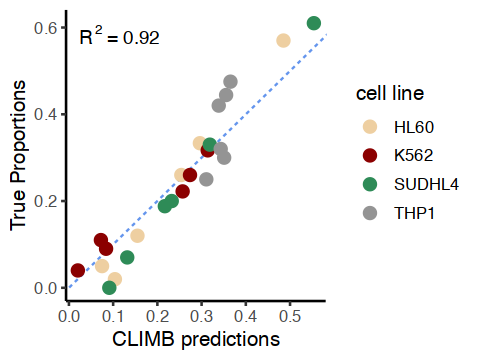

In [32]:
# Plot and display the results 
options(repr.plot.width=4, repr.plot.height=3)
df_cor = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(climb_prop)))
colnames(df_cor) = c('cell line', 'True Proportions', 'x', 'CLIMB predictions')
g = ggplot(df_cor) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=`True Proportions`, x=`CLIMB predictions`, colour=`cell line`), size=3) + theme_classic2() + 
    stat_poly_eq(aes(y=`True Proportions`, x=`CLIMB predictions`)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('CLIMB predictions')
#pdf('results/fig2/climb_scatter.pdf', width=4, height=3) ; g ; dev.off()
g

## CLIMB without DWLS-like weights

Corresponds to CLIMB method in the previous version of the manuscript

In [33]:
climb_out = climb(sc.es, bulk.es, dwls_weights = F, norm_coefs = T, mode='abundance') # norm_coefs is now true by default in CLIMB package
climb_prop = climb_out$props
# Compute all metrics
climb.res = comp_rows_and_cols(climb_prop, true_prop)

ABUNDANCE mode: predicting cell-type proportions in bulks

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 



In [34]:
## REPRODUCING RESULTS FROM FIRST MANUSCRIPT 
# option dwls_weight=FALSE and norm_coefs=TRUE
# median pearson correlation per samples (6 values)
# From the run:
print(median(unlist(climb.res[1])))
print(climb.res[1])

[1] 0.9658729
[[1]]
[1] 0.7497600 0.9860816 0.9600819 0.9368870 0.9716639 0.9964733



## CLIMB without Coefficient Normalization

Reviewer #3 ran CLIMB without coefficient normalization (norm_coefs=F), and without the newly added weights (dwls_weights=F). 

Here are the reproduced results:

In [35]:
climb_out2 = climb(sc.es, bulk.es, mode='abundance', norm_coefs = F, dwls_weights = F)
climb_prop2 = climb_out2$props
climb.res2 = comp_rows_and_cols(climb_prop2, true_prop)
# pearson correlation per samples (6 values)
print(median(unlist(climb.res2[1])))
climb.res2[1]

ABUNDANCE mode: predicting cell-type proportions in bulks

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 



[1] 0.8967051


[[1]]
[1] -0.02086949  0.90383830  0.88957195  0.98319386  0.90798565  0.66692194

which corresponds to the results obtained by reviewer #3

## Fig. 2B

pdf 
  2

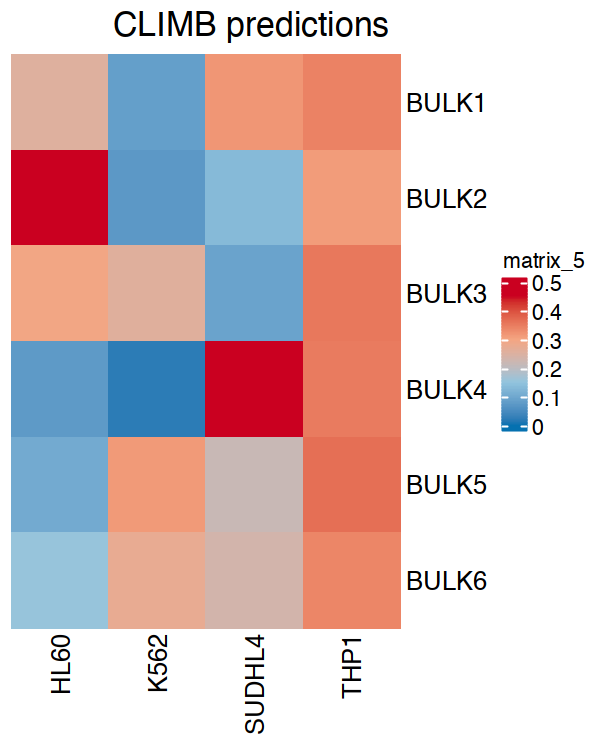

In [44]:
rownames(climb_prop) = rownames(true_prop)
options(repr.plot.width=4, repr.plot.height=5, repr.plot.res=150)
col_fun = colorRamp2(c(0, 0.15, 0.3, 0.45), rev(brewer.pal(4,"RdBu"))) # we use the same color breaks for both heatmap
h_climb <- Heatmap(climb_prop, col=col_fun, cluster_rows = F, cluster_columns = F, show_row_dend = F, show_column_dend = F)
d_climb = draw(h_climb, column_title="CLIMB predictions", column_title_gp=grid::gpar(fontsize=16))
pdf('results/fig2/climb_prediction_heatmap.pdf', width=4, height=5) ; d_climb ; dev.off()
d_climb

pdf 
  2

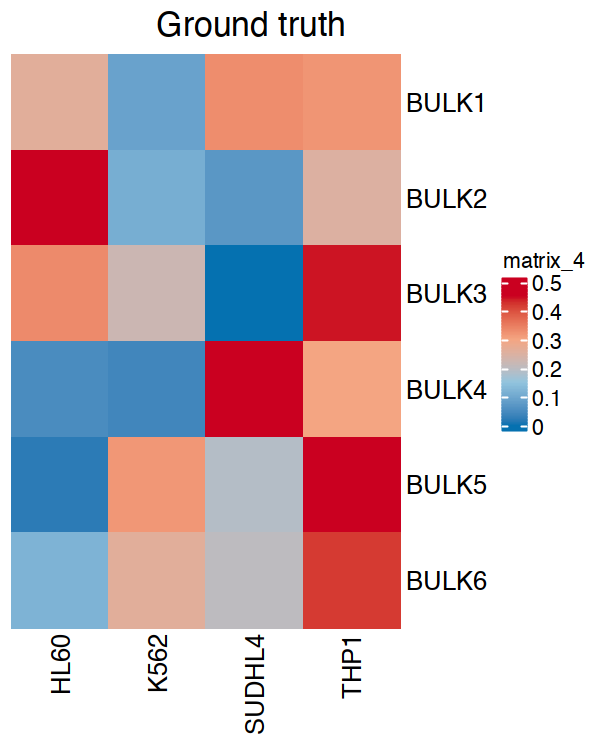

In [43]:
options(repr.plot.width=4, repr.plot.height=5, repr.plot.res=150)
h_true <- Heatmap(true_prop, col=col_fun, cluster_rows = F,  cluster_columns = F, show_row_dend = F, show_column_dend = F)
d_true = draw(h_true, column_title="Ground truth", column_title_gp=grid::gpar(fontsize=16))
pdf('results/fig2/true_prop_heatmap.pdf', width=4, height=5) ; d_true ; dev.off()
d_true

## BayesPrism Deconvolution

We provide here the code used to run BayesPrism and reproduce results. Unfortunately we did not manage to install it on Renku, thus we will rely on pre-computed cell-type proportions.

In [45]:
bayesprism_prop = all_props$BayesPrism
median(all_res$BayesPrism[[1]])

[1] 0.7902794

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

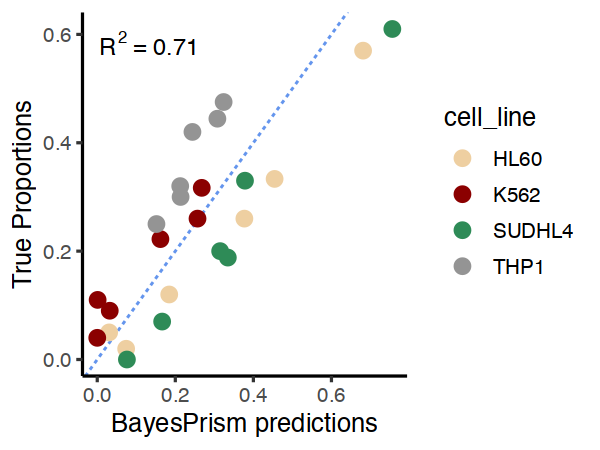

In [46]:
options(repr.plot.width=4, repr.plot.height=3)
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(bayesprism_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'bayesprism_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(x=bayesprism_prop, y=true.prop, colour=cell_line), size=3) + theme_classic2() + 
    stat_poly_eq(aes(x=bayesprism_prop, y=true.prop)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('BayesPrism predictions')  
pdf('results/fig2/bayesprism_scatter.pdf', width=4, height=3) ; g ; dev.off()
g

## MuSiC Deconvolution

We will run here MuSiC deconvolution, which is also used to derive NNLS predictions.

In [47]:
music_prop = all_props$MuSiC
median(all_res$MuSiC[[1]])

[1] 0.7285475

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

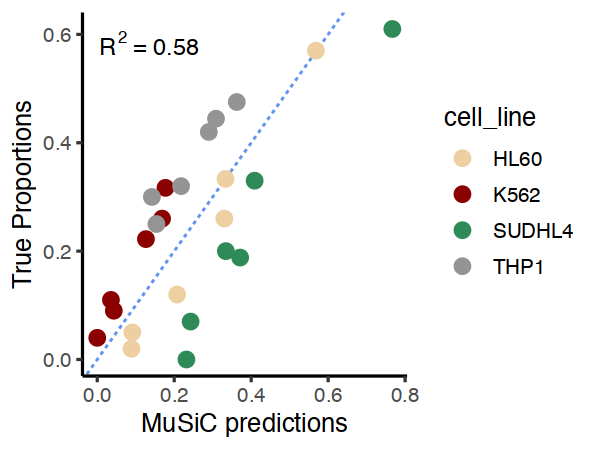

In [48]:
options(repr.plot.width=4, repr.plot.height=3)
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(music_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'music_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(x=music_prop, y=true.prop, colour=cell_line), size=3) + theme_classic2() + 
    stat_poly_eq(aes(x=music_prop, y=true.prop)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('MuSiC predictions') 
pdf('results/fig2/scatter_music.pdf', width=4, height=3) ; g ; dev.off()
g

## NNLS 

NNLS shows very bad correlation. Is it a problem with the MuSiC implementation ?

In [49]:
nnls_prop = all_props$NNLS
median(all_res$NNLS[[1]])

[1] -0.23796

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

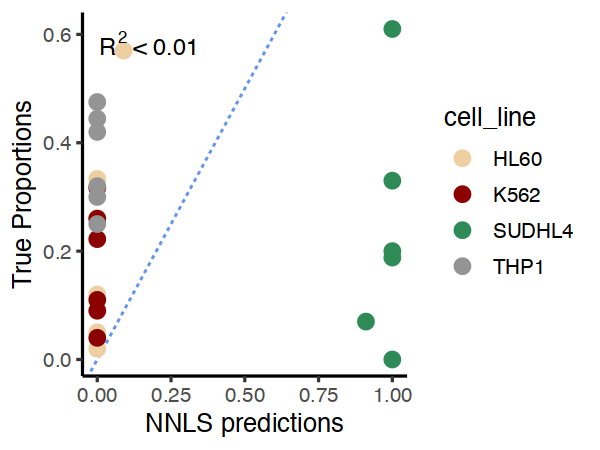

In [52]:
# Draw MuSiC predictons against true proportions
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(nnls_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'nnls_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true.prop, x=nnls_prop, colour=cell_line), size=3) + theme_classic2() + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    stat_poly_eq(aes(y=true.prop, x=nnls_prop)) + 
    ylab('True Proportions') + xlab('NNLS predictions') 
pdf('results/fig2/scatter_nnls.pdf', width=6, height=5) ; g ; dev.off()
g

## Re-implement NNLS

Here we try to re-implement ourself NNLS using 'nnls' R package, and building the signature matrix with simple average expression per cell type

In [53]:
sign_mat = aggregate(t(exprs(sc.es)), list(sc.es$cellType), mean)
rownames(sign_mat) = sign_mat$`Group.1`
sign_mat = sign_mat[,-1]
sign_mat = t(sign_mat)[,colnames(true_prop)]

In [54]:
nnls_props_ = list()
for(i in 1:6){
    nnls_props_[[i]] = nnls(sign_mat, exprs(bulk.es)[,i])$x
}
nnls_prop_ = do.call(rbind,nnls_props_)
nnls_prop_ = nnls_prop_ / rowSums(nnls_prop_) # normalize coefficients

In [56]:
print(paste0('correlation with MuSiC-derived NNLS: ',cor(as.vector(nnls_prop_), as.vector(nnls_prop))))
print(paste0('correlation with true proportions:   ',cor(as.vector(nnls_prop_), as.vector(true_prop))))

[1] "correlation with MuSiC-derived NNLS: 0.999990083402501"
[1] "correlation with true proportions:   -0.0314205426633778"


NNLS seems indeed to perform very bad in that situation no matter how we implement it

## CiberSortX Deconvolution 

As CSX was run on the CSX website, we directly load the ouput. CSX was ran with all default settings.

In [57]:
csx_prop = all_props$CiberSortX
median(all_res$CiberSortX[[1]])

[1] 0.6868062

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

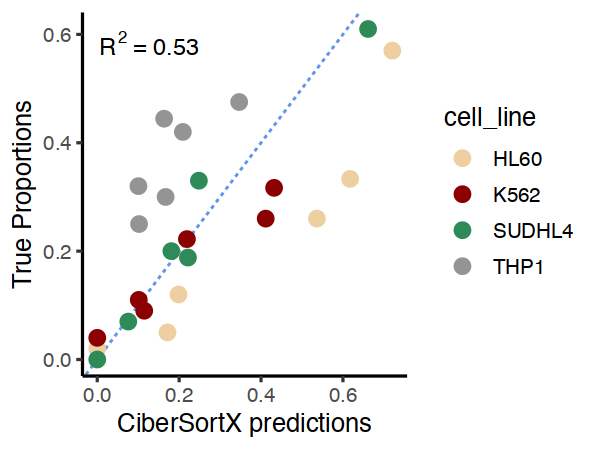

In [58]:
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(csx_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'csx_props')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true.prop, x=csx_props, colour=cell_line), size=3) + theme_classic2() + 
    stat_poly_eq(aes(y=true.prop, x=csx_props)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('CiberSortX predictions')
pdf('results/fig2/scatter_cibersortx.pdf', width=4, height=3) ; g ; dev.off()
g

## TAPE method 

TAPE is a python method that can be run through another notebook `rev_TAP_launch.ipynb`. The package is not working on Renku but TAPE/Scaden methods can both be installed and ran through our notebook for reproducing results.

In [60]:
tape_prop = all_props$TAPE
median(all_res$TAPE[[1]])

[1] 0.5982657

## Scaden method

Scaden method can be ran through the same notebook as TAPE and relies on the same input matrices.

In [61]:
scaden_prop = all_props$Scaden
median(all_res$Scaden[[1]])

[1] 0.9722838

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

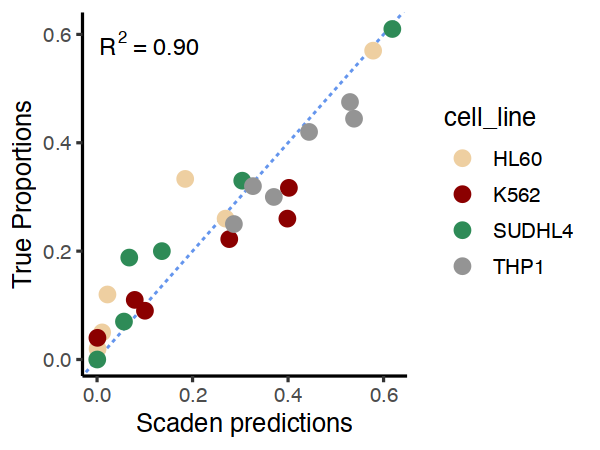

In [63]:
options(repr.plot.width=4, repr.plot.height=3)
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(scaden_prop)))
colnames(df_msc) = c('cell_line', 'true_prop', 'x', 'scaden_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true_prop, x=scaden_prop, colour=cell_line), size=3) + theme_classic2() +              
    stat_poly_eq(aes(y=true_prop, x=scaden_prop)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('Scaden predictions') 
pdf('results/fig2/scatter_scaden.pdf', width=4, height=3) ; g ; dev.off()
g

Of note: Scaden seems to have a little variability in its output between different runs

## Make statistics to compare correlation / errors 

### First we compare correlation using package 'cocor'

In [65]:
df_props = data.frame(true=as.vector(as.matrix(true_prop)), scaden=as.vector(as.matrix(all_props$Scaden)), 
                      tape=as.vector(as.matrix(all_props$TAPE)), climb=as.vector(as.matrix(all_props$CLIMB)),
                      csx=as.vector(as.matrix(all_props$CiberSortX)), bayesprism=as.vector(as.matrix(all_props$BayesPrism)),
                      music=as.vector(as.matrix(all_props$MuSiC)), nnls=as.vector(as.matrix(all_props$NNLS)),
                      random=as.vector(as.matrix(all_props$Random)), bisque=as.vector(as.matrix(all_props$BisqueRNA)))

In [66]:
# Run Cocor package to compare CLIMB coreelation against ground truth versus other method's correlations
cocor_res.scaden =     cocor(~true + climb | true + scaden, df_props, alternative='greater')
cocor_res.tape =       cocor(~true + climb | true + tape, df_props, alternative='greater')
cocor_res.csx =        cocor(~true + climb | true + csx, df_props, alternative='greater')
cocor_res.bayesprism = cocor(~true + climb | true + bayesprism, df_props, alternative='greater')
cocor_res.music =      cocor(~true + climb | true + music, df_props, alternative='greater')
cocor_res.nnls =       cocor(~true + climb | true + nnls, df_props, alternative='greater')
cocor_res.bisque =     cocor(~true + climb | true + bisque, df_props, alternative='greater')
cocor_res.random =     cocor(~true + climb | true + random, df_props, alternative='greater')

In [67]:
df_signif = data.frame(pvalue=c(cocor_res.scaden@pearson1898$p.value, cocor_res.tape@pearson1898$p.value, 
                    cocor_res.csx@pearson1898$p.value, cocor_res.bayesprism@pearson1898$p.value,
                    cocor_res.music@pearson1898$p.value, cocor_res.nnls@pearson1898$p.value,
                    cocor_res.bisque@pearson1898$p.value, cocor_res.random@pearson1898$p.value),
           comparison=c('CLIMB_vs_Scaden', 'CLIMB_vs_TAPE', 'CLIMB_vs_CiberSortX', 'CLIMB_vs_BayesPrism',
                        'CLIMB_vs_MUSIC', 'CLIMB_vs_NNLS', 'CLIMB_vs_BisqueRNA', 'CLIMB_vs_Random'))
df_signif$signif = 'n.s'
df_signif$signif[df_signif$pvalue < 0.05] <- '*'
df_signif$signif[df_signif$pvalue < 0.01] <- '**'
df_signif$signif[df_signif$pvalue < 0.001] <- '***'
df_signif$signif[df_signif$pvalue < 0.0001] <- '****'

In [68]:
# Show results in a table: 
df_signif[rev(order(df_signif$pvalue)),]

,pvalue,comparison,signif
,<dbl>,<chr>,<chr>
1,2.905948e-01,CLIMB_vs_Scaden,n.s
4,1.402851e-02,CLIMB_vs_BayesPrism,*
5,6.831207e-03,CLIMB_vs_MUSIC,**
3,5.814937e-03,CLIMB_vs_CiberSortX,**
2,3.462321e-03,CLIMB_vs_TAPE,**
7,4.591631e-06,CLIMB_vs_BisqueRNA,****
6,5.222965e-07,CLIMB_vs_NNLS,****
8,1.573444e-10,CLIMB_vs_Random,****


## Plot the comparative results 

Use only per-sample metrics 

In [70]:
# Change the Metric by setting type.err to 1, 2, 3, or 4
generate_comp_plot <- function(type.err=1){
    #type.err , 1=pcor, 2=scor, 3=r_square, 4=rmse
    type.err.l = list('PCC', 'SCC', 'R2', 'RMSE')
    methods = c('MuSiC', 'NNLS', 'CLIMB', 'TAPE', 'Scaden', 'Bisque', 'Random', 'BayesPrism', 'CiberSortX')
    df_scor = data.frame(cbind(all_res$MuSiC[[type.err]], all_res$NNLS[[type.err]], 
                               all_res$CLIMB[[type.err]], all_res$TAPE[[type.err]], all_res$Scaden[[type.err]],
                               all_res$BisqueRNA[[type.err]], all_res$Random[[type.err]], all_res$BayesPrism[[type.err]], 
                               all_res$CiberSortX[[type.err]]))
    colnames(df_scor) = methods
    levels_ = colnames(df_scor)[rev(order(colMedians(as.matrix(df_scor), na.rm = T)))]
    if(type.err.l[[type.err]] == 'RMSE'){levels_ = rev(levels_)}
    df_scor_m = reshape2::melt(df_scor)
    df_scor_m$variable = factor(df_scor_m$variable, levels = levels_) 
    g_rows = ggplot(df_scor_m) + geom_boxplot(aes(x=variable, y=value, color=variable), outlier.shape = NA) + theme_classic() +
                geom_jitter(aes(x=variable, y=value, color=variable)) + theme_classic() +
                scale_color_manual(values=ifelse(grepl('CLIMB', levels_), 'darkred', 'grey38')) + 
                theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
                xlab('') + ylab(type.err.l[type.err]) #+ coord_flip() # ylab(expression(pa
    return(g_rows)
}

# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse 
g_pcc = generate_comp_plot(type.err=1) # PCC
g_scc = generate_comp_plot(type.err=2) # SCC
g_r2 = generate_comp_plot(type.err=3) # R-square
g_rmse = generate_comp_plot(type.err=4) # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

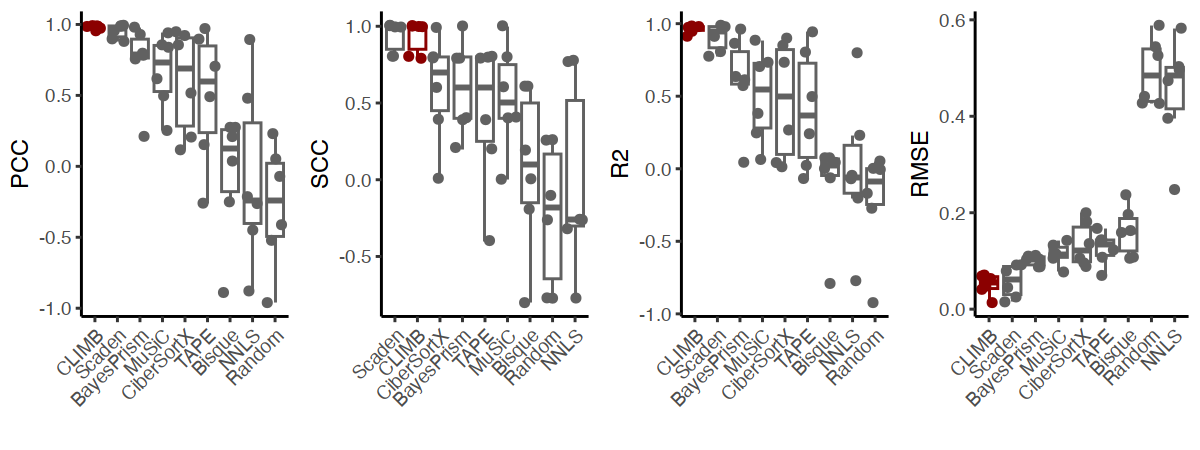

In [73]:
options(repr.plot.width=8, repr.plot.height=3)
g_arr = ggarrange(g_pcc, g_scc, g_r2, g_rmse, ncol = 4, nrow = 1)
pdf('results/fig2/comparative_boxplots.pdf', width=8, height=3) ; g_arr ; dev.off()
g_arr

## Ranking method according to 4 metrics

We rank deconvolution methods according to the median values of the "bulk level" comparison. Each bulk sample get four accuracy metrics: PCC, SCC, RMSE, and R-square, and deconvolution methods are ranked according to their median values.

In [74]:
all_rmse_cl = c(median(all_res$Random[[4]]), median(all_res$TAPE[[4]]), median(all_res$NNLS[[4]]), median(all_res$BisqueRNA[[4]]),
             median(all_res$MuSiC[[4]]), median(all_res$Scaden[[4]]), median(all_res$BayesPrism[[4]]),
             median(all_res$CiberSortX[[4]]), median(all_res$CLIMB[[4]]))
all_pcc_cl = c(median(all_res$Random[[1]]), median(all_res$TAPE[[1]]), median(all_res$NNLS[[1]]), median(all_res$BisqueRNA[[1]]),
             median(all_res$MuSiC[[1]]), median(all_res$Scaden[[1]]), median(all_res$BayesPrism[[1]]),
             median(all_res$CiberSortX[[1]]), median(all_res$CLIMB[[1]]))
all_scc_cl = c(median(all_res$Random[[2]]), median(all_res$TAPE[[2]]), median(all_res$NNLS[[2]]), median(all_res$BisqueRNA[[2]]),
             median(all_res$MuSiC[[2]]), median(all_res$Scaden[[2]]), median(all_res$BayesPrism[[2]]),
             median(all_res$CiberSortX[[2]]), median(all_res$CLIMB[[2]]))
all_r2_cl = c(median(all_res$Random[[3]]), median(all_res$TAPE[[3]]), median(all_res$NNLS[[3]]), median(all_res$BisqueRNA[[3]]),
             median(all_res$MuSiC[[3]]), median(all_res$Scaden[[3]]), median(all_res$BayesPrism[[3]]),
             median(all_res$CiberSortX[[3]]), median(all_res$CLIMB[[3]]))

In [75]:
df = data.frame(rank_rmse_cl=rank(all_rmse_cl),rank_pcc_cl=rank(-1*all_pcc_cl),
                rank_scc_cl=rank(-1*all_scc_cl), rank_r2_cl=rank(-1*all_r2_cl))

In [76]:
df$mean_rank = rowMeans(as.matrix(df))
df$sd_rank = rowSds(as.matrix(df))
rownames(df) = c('Random', 'TAPE', 'NNLS', 'BisqueRNA', 'MuSiC', 'Scaden', 'BayesPrism', 'CiberSortX', 'CLIMB')
df$method = rownames(df)
df$method = factor(df$method, levels=rev(df$method[order(df$mean_rank)]))

In [77]:
# Show results in a table : 
df

,rank_rmse_cl,rank_pcc_cl,rank_scc_cl,rank_r2_cl,mean_rank,sd_rank,method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Random,8,9,8.0,9,8.500,0.5000000,Random
TAPE,6,6,4.5,6,5.625,0.6495191,TAPE
NNLS,9,8,9.0,8,8.500,0.5000000,NNLS
BisqueRNA,7,7,7.0,7,7.000,0.0000000,BisqueRNA
MuSiC,4,4,6.0,4,4.500,0.8660254,MuSiC
Scaden,2,2,1.5,2,1.875,0.2165064,Scaden
BayesPrism,3,3,4.5,3,3.375,0.6495191,BayesPrism
CiberSortX,5,5,3.0,5,4.500,0.8660254,CiberSortX
CLIMB,1,1,1.5,1,1.125,0.2165064,CLIMB


pdf 
  2

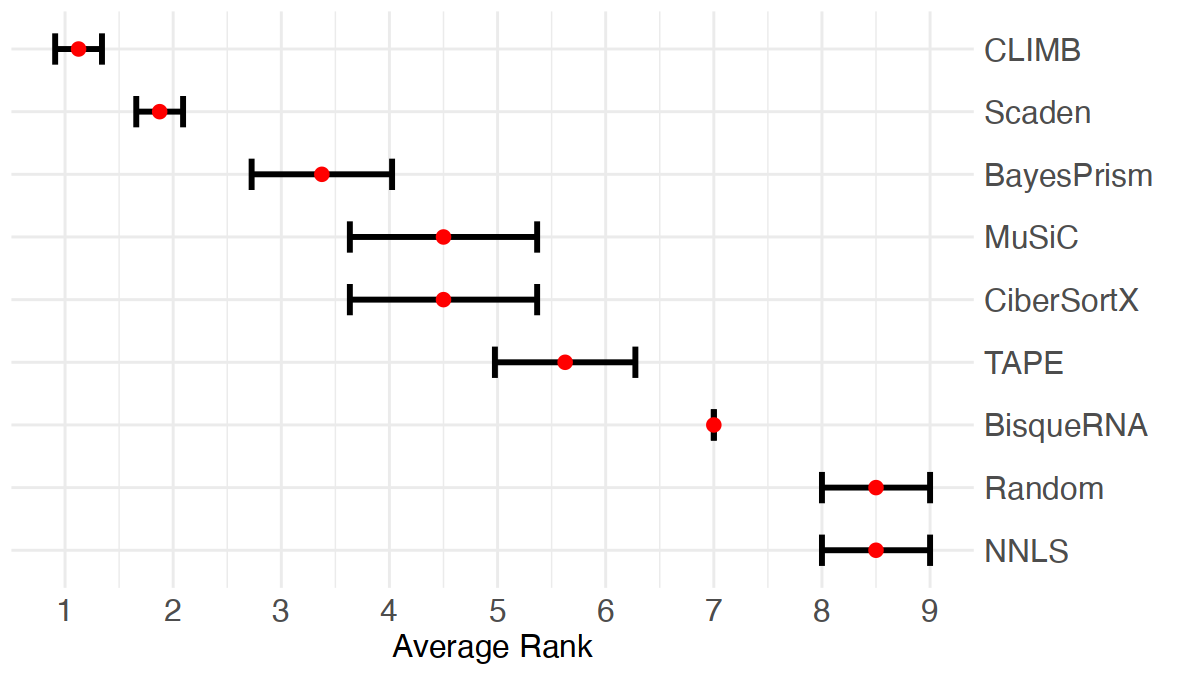

In [79]:
options(repr.plot.width=8, repr.plot.height=4.5)
g <- ggplot() + geom_errorbar(data=df, aes(y=method, xmin=mean_rank-sd_rank, xmax=mean_rank+sd_rank), width=0.5, size=1, color="black") +
    geom_point(data=df, aes(x=mean_rank, y=method), size=2.5, color='red') + scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 15), text=element_text(size = 15)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "right")
pdf('results/fig2/comparative_rankings.pdf', width=8, height=4.5) ; g ; dev.off()
g

In [80]:
df_wilcox = data.frame(pvalue=c(wilcox.test(num(df['CLIMB',1:4]), num(df['Scaden',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['BayesPrism',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['MuSiC',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['CiberSortX',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['TAPE',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['Random',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['BisqueRNA',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['NNLS',1:4]), exact = FALSE)$p.value),
                       comparison=c('CLIMB_vs_Scaden',  'CLIMB_vs_BayesPrism', 'CLIMB_vs_MUSIC', 'CLIMB_vs_CiberSortX','CLIMB_vs_TAPE', 
                          'CLIMB_vs_Random','CLIMB_vs_BisqueRNA', 'CLIMB_vs_NNLS'))
df_wilcox$signif = 'n.s'
df_wilcox$signif[df_wilcox$pvalue < 0.05] <- '*'
df_wilcox$signif[df_wilcox$pvalue < 0.01] <- '**'
df_wilcox$signif[df_wilcox$pvalue < 0.001] <- '***'
df_wilcox$signif[df_wilcox$pvalue < 0.0001] <- '****'
df_wilcox

pvalue,comparison,signif
<dbl>,<chr>,<chr>
0.03247332,CLIMB_vs_Scaden,*
0.02283622,CLIMB_vs_BayesPrism,*
0.02283622,CLIMB_vs_MUSIC,*
0.02283622,CLIMB_vs_CiberSortX,*
0.02283622,CLIMB_vs_TAPE,*
0.02465329,CLIMB_vs_Random,*
0.01770607,CLIMB_vs_BisqueRNA,*
0.02465329,CLIMB_vs_NNLS,*


every p-values are now comprise between 0.01 and 0.05. Because we restricted our analysis to the comparison "per sample" only, we have less data points (ranks) to compare. Nevertheless, the comparison of CLIMB vs Scaden now became significant.

## New analysis for studying potential bias 

According to reviewer #1, CLIMB model could be potentially biased by unbalanced cell-type proportions in the reference matric C. 

### Is there a correlation between proportions in C and proportions predicted by CLIMB ?

In [81]:
ref_props = table(sc.es$cellType) / sum(table(sc.es$cellType))

In [82]:
cor(t(climb_prop), ref_props)

BULK1,-0.9672019
BULK2,-0.5059185
BULK3,0.1663398
BULK4,-0.7293815
BULK5,0.3145413
BULK6,0.1518266


In [83]:
gs = list()
for(n in 1:6){
   gs[[n]] = ggplot(data.frame(climb=climb_prop[n,], ref_props=ref_props), aes(x=climb, y=ref_props.Freq)) + 
    geom_point() + stat_correlation(aes(y=ref_props.Freq, x=climb)) + 
    stat_poly_line(formula = y ~ x, color = "red") +
    xlab('CLIMB predictions') + ylab('Proportions in C') + theme_minimal()
}

pdf 
  2

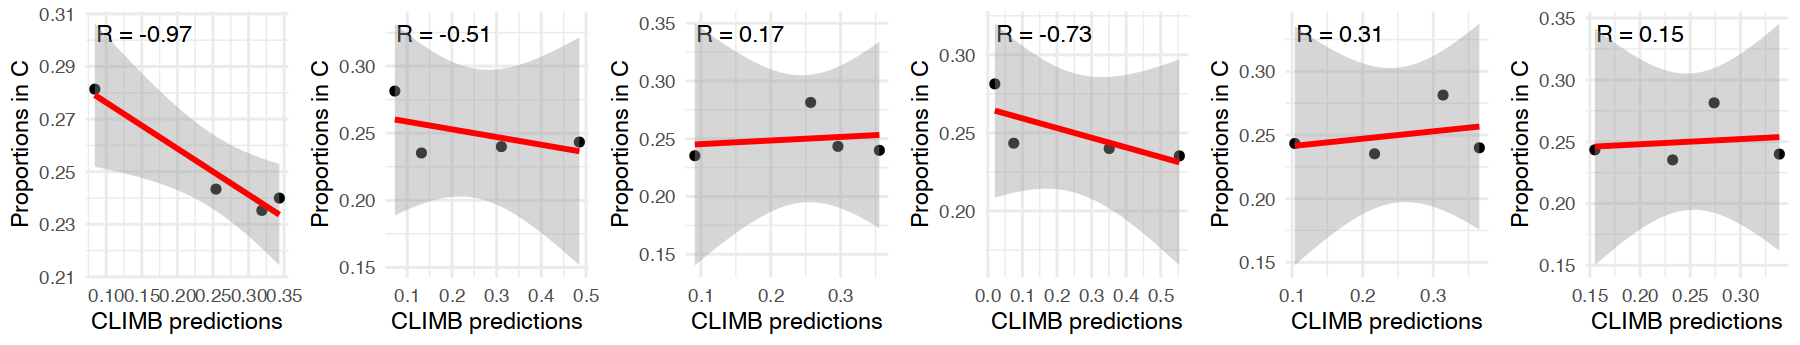

In [84]:
options(repr.plot.width=12, repr.plot.height=2.3, repr.plot.res=150)
garr = ggarrange(plotlist=gs, ncol=6)
pdf('results/fig2/bias_C_props_vs_CLIMB_props.pdf', width=12, height=2.3) ; garr ; dev.off()
garr

Moreover, we induce an increasing imbalance to study the stability of CLIMB upon balanced / unbalanced cell-type proportions in the matrix C. We generate 3 contexts:
- 'same' means that we subset cell in reference matrix C so that it has the same proportions as sample n
- 'balanced' means we subset cells in reference martix C and keep balanced number of cells among cell types
- 'inv' means we subset cells in reference matric C to generate 'inverse' proportions compared to the true proportions in bulk n. (e.g. 20%/80% becomes 80%/20%)

We compare the ability to deal with this bias of the original CLIMB method from previous manuscript, with the new version implementing weights inspired by DWLS method. 

In [86]:
deconvolution_scaden_only <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING: launching TAPE / Scaden from the command line induces figures popping up
    # which blocks the process (figures have to be closed manually). 
    # To prevent these figures to be made, one can comment lines 103-109,115-119,128-131, 
    # and 172-176 in the file 'tape_scaden_env/lib/python3.7/site-packages/TAPE/utils.py'
    message('Launch Scaden deconvolution')
    # Launch bash script that will launch environment and python script
    system(paste0('bash launch_Scaden_only.sh ', tab_dir, '/tape_scaden_scmat_expr.csv ',
                  tab_dir, '/tape_scaden_bulks_expr.csv ',
                  'data/GeneLength.txt ',
                  tab_dir, '/'), wait=TRUE)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(tmp_dir,'/scaden_prop_reformat.csv'), quote=F)
    return(scaden_prop)
}

In [93]:
set_seed = 1

In [87]:
# Create folders
message('Creating folders')
tmp_dir = paste0('data/invitro_climb/bias_analysis_tmp/')
dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)

Creating folders



In [163]:
climb_all_same = list() ; climb_match_same = list()
climb_all_same_50 = list() ; climb_match_same_50 = list()
climb_all_inv = list()  ; climb_match_inv = list()
climb_all_inv_50 = list() ; climb_match_inv_50 = list()
climb_all_bal = list() ; climb_match_bal = list()

In [164]:
new_climb_all_same = list() ; new_climb_match_same = list()
new_climb_all_same_50 = list() ; new_climb_match_same_50 = list()
new_climb_all_inv = list()  ; new_climb_match_inv = list()
new_climb_all_inv_50 = list() ; new_climb_match_inv_50 = list()
new_climb_all_bal = list() ; new_climb_match_bal = list()

In [165]:
scaden_all_same = list() ; scaden_match_same = list()
scaden_all_same_50 = list() ; scaden_match_same_50 = list()
scaden_all_inv = list()  ; scaden_match_inv = list()
scaden_all_inv_50 = list() ; scaden_match_inv_50 = list()
scaden_all_bal = list() ; scaden_match_bal = list()

In [166]:
ratio_same = list() ; ratio_same_50 = list() ; ratio_inv = list() ; ratio_inv_50 = list() ; ratio_bal = list()

In [167]:
## Takes around 10h to run (Scaden is ran 30 times, around 45min per run)
for(n in 1:dim(true_prop)[1]){
    ### Induce imbalances in cell-type proportions that follows input bulk sample n ###
    message('Positively correlated proportions')
    ratio_cells_to_keep = (true_prop[n,]+0.1)/max(true_prop[n,]+0.1)
    cells_to_keep = list()
    for(k in 1:4){
        celltype_k = names(ratio_cells_to_keep[k])
        ratio_k = num(ratio_cells_to_keep[k])
        print(paste0('we select ', round(ratio_k*100), '% of cell from type ', celltype_k))
        sc.es.sub = sc.es[,sc.es$cellType == celltype_k]
        set.seed(set_seed)
        cells_to_keep[[k]] = sample(colnames(sc.es.sub), round(length(colnames(sc.es.sub))*ratio_k))
    }
    cell_subset = c(c(cells_to_keep[[1]]), c(cells_to_keep[[2]]), c(cells_to_keep[[3]]), c(cells_to_keep[[4]]))
    sc.es.sub = sc.es[,colnames(sc.es) %in% cell_subset]
    sc.es.sub$cellType = factor(sc.es.sub$cellType, levels=c('HL60', 'K562', 'SUDHL4', 'THP1'))
    ## Run CLIMB deconvolution using modified reference ## 
    climb_out = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = F, mode='abundance', verbose = F)
    climb_prop = climb_out$props
    climb_all_same[[n]] = unlist(comp_rows_and_cols(climb_prop, true_prop)[1])
    climb_match_same[[n]] = climb_all_same[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between CLIMB (no weights) and true for sample n: ', climb_match_same[[n]]))
    ## Run new version of CLIMB with iterations and down-sampling of cells
    new_climb_prop = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = T, mode='abundance', verbose = F)$props
    new_climb_all_same[[n]] = unlist(comp_rows_and_cols(new_climb_prop, true_prop)[1])
    new_climb_match_same[[n]] = new_climb_all_same[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between CLIMB and true for sample n: ', new_climb_match_same[[n]]))
    ratio_same[[n]] = ratio_cells_to_keep
    ## Run Scaden 
    write_tables_tape_scaden(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden_only(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    scaden_prop = load_scaden_prop(tmp_dir, tmp_dir, celltype_names)
    scaden_all_same[[n]] = unlist(comp_rows_and_cols(as.matrix(scaden_prop), true_prop)[1])
    scaden_match_same[[n]] = scaden_all_same[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between Scaden and true for sample n: ', scaden_match_same[[n]]))
    
    ### Induce imbalances in cell-type proportions that follows input bulk sample n ###
    message('Positively correlated proportions - flattened 50%')
    ratio_cells_to_keep_50 = (true_prop[n,]+1)/max(true_prop[n,]+1)
    cells_to_keep = list()
    for(k in 1:4){
        celltype_k = names(ratio_cells_to_keep_50[k])
        ratio_k = num(ratio_cells_to_keep_50[k])
        print(paste0('we select ', round(ratio_k*100), '% of cell from type ', celltype_k))
        sc.es.sub = sc.es[,sc.es$cellType == celltype_k]
        set.seed(set_seed)
        cells_to_keep[[k]] = sample(colnames(sc.es.sub), round(length(colnames(sc.es.sub))*ratio_k))
    }
    cell_subset = c(c(cells_to_keep[[1]]), c(cells_to_keep[[2]]), c(cells_to_keep[[3]]), c(cells_to_keep[[4]]))
    sc.es.sub = sc.es[,colnames(sc.es) %in% cell_subset]
    sc.es.sub$cellType = factor(sc.es.sub$cellType, levels=c('HL60', 'K562', 'SUDHL4', 'THP1'))
    ## Run CLIMB deconvolution using modified reference ## 
    climb_out = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = F, mode='abundance', verbose = F)
    climb_prop = climb_out$props
    climb_all_same_50[[n]] = unlist(comp_rows_and_cols(climb_prop, true_prop)[1])
    climb_match_same_50[[n]] = climb_all_same_50[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between CLIMB (no weights) and true for sample n: ', climb_match_same_50[[n]]))
    ## Run new version of CLIMB with iterations and down-sampling of cells
    new_climb_prop = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = T, mode='abundance', verbose = F)$props
    new_climb_all_same_50[[n]] = unlist(comp_rows_and_cols(new_climb_prop, true_prop)[1])
    new_climb_match_same_50[[n]] = new_climb_all_same_50[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between CLIMB and true for sample n: ', new_climb_match_same[[n]]))
    ratio_same_50[[n]] = ratio_cells_to_keep_50
    ## Run Scaden 
    write_tables_tape_scaden(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden_only(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    scaden_prop = load_scaden_prop(tmp_dir, tmp_dir, celltype_names)
    scaden_all_same_50[[n]] = unlist(comp_rows_and_cols(as.matrix(scaden_prop), true_prop)[1])
    scaden_match_same_50[[n]] = scaden_all_same_50[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between Scaden and true for sample n: ', scaden_match_same_50[[n]]))
    
    ### Redo the same with inverse-ordered proportion ###
    message('Negatively correlated proportions')
    ratio_cells_to_keep_inv = ratio_cells_to_keep[order(ratio_cells_to_keep*-1)]
    names(ratio_cells_to_keep_inv) = names(ratio_cells_to_keep)[order(ratio_cells_to_keep)]
    ratio_cells_to_keep_inv = ratio_cells_to_keep_inv[names(ratio_cells_to_keep)]
    cells_to_keep = list()
    for(k in 1:4){
        celltype_k = names(ratio_cells_to_keep_inv[k])
        ratio_k = num(ratio_cells_to_keep_inv[k])
        print(paste0('we select ', round(ratio_k*100), '% of cell from type ', celltype_k))
        sc.es.sub = sc.es[,sc.es$cellType == celltype_k]
        set.seed(set_seed)
        cells_to_keep[[k]] = sample(colnames(sc.es.sub), round(length(colnames(sc.es.sub))*ratio_k))
    }
    cell_subset = c(c(cells_to_keep[[1]]), c(cells_to_keep[[2]]), c(cells_to_keep[[3]]), c(cells_to_keep[[4]]))
    sc.es.sub = sc.es[,colnames(sc.es) %in% cell_subset]
    sc.es.sub$cellType = factor(sc.es.sub$cellType, levels=c('HL60', 'K562', 'SUDHL4', 'THP1'))
    ## Run CLIMB deconvolution using modified reference ## 
    climb_out = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = F, mode='abundance', verbose = F)
    climb_prop = climb_out$props
    climb_all_inv[[n]] = unlist(comp_rows_and_cols(climb_prop, true_prop)[1])
    climb_match_inv[[n]] = climb_all_inv[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between CLIMB (no weights) and true for sample n: ', climb_match_inv[[n]]))
    ## Run new version of CLIMB with iterations and down-sampling of cells
    new_climb_prop = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = T, mode='abundance', verbose = F)$props
    new_climb_all_inv[[n]] = unlist(comp_rows_and_cols(new_climb_prop, true_prop)[1])
    new_climb_match_inv[[n]] = new_climb_all_inv[[n]][n]
    message(paste0('Correlation between CLIMB and true for sample n: ', new_climb_match_inv[[n]]))
    ratio_inv[[n]] = ratio_cells_to_keep_inv
    ## Run Scaden 
    write_tables_tape_scaden(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden_only(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    scaden_prop = load_scaden_prop(tmp_dir, tmp_dir, celltype_names)
    scaden_all_inv[[n]] = unlist(comp_rows_and_cols(as.matrix(scaden_prop), true_prop)[1])
    scaden_match_inv[[n]] = scaden_all_inv[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between Scaden and true for sample n: ', scaden_match_inv[[n]]))

    ### Redo the same with inverse-ordered proportion ###
    message('Negatively correlated proportions - flattened 50%')
    ratio_cells_to_keep_inv = ratio_cells_to_keep[order(ratio_cells_to_keep*-1)]
    names(ratio_cells_to_keep_inv) = names(ratio_cells_to_keep)[order(ratio_cells_to_keep)]
    ratio_cells_to_keep_inv = ratio_cells_to_keep_inv[names(ratio_cells_to_keep)]
    ratio_cells_to_keep_inv_50 = (ratio_cells_to_keep_inv+1)/(max(ratio_cells_to_keep_inv+1))
    cells_to_keep = list()
    for(k in 1:4){
        celltype_k = names(ratio_cells_to_keep_inv_50[k])
        ratio_k = num(ratio_cells_to_keep_inv_50[k])
        print(paste0('we select ', round(ratio_k*100), '% of cell from type ', celltype_k))
        sc.es.sub = sc.es[,sc.es$cellType == celltype_k]
        set.seed(set_seed)
        cells_to_keep[[k]] = sample(colnames(sc.es.sub), round(length(colnames(sc.es.sub))*ratio_k))
    }
    cell_subset = c(c(cells_to_keep[[1]]), c(cells_to_keep[[2]]), c(cells_to_keep[[3]]), c(cells_to_keep[[4]]))
    sc.es.sub = sc.es[,colnames(sc.es) %in% cell_subset]
    sc.es.sub$cellType = factor(sc.es.sub$cellType, levels=c('HL60', 'K562', 'SUDHL4', 'THP1'))
    ## Run CLIMB deconvolution using modified reference ## 
    climb_out = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = F, mode='abundance', verbose = F)
    climb_prop = climb_out$props
    climb_all_inv_50[[n]] = unlist(comp_rows_and_cols(climb_prop, true_prop)[1])
    climb_match_inv_50[[n]] = climb_all_inv_50[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between CLIMB (no weights) and true for sample n: ', climb_match_inv_50[[n]]))
    ## Run new version of CLIMB with iterations and down-sampling of cells
    new_climb_prop = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = T, mode='abundance', verbose = F)$props
    new_climb_all_inv_50[[n]] = unlist(comp_rows_and_cols(new_climb_prop, true_prop)[1])
    new_climb_match_inv_50[[n]] = new_climb_all_inv_50[[n]][n]
    message(paste0('Correlation between CLIMB and true for sample n: ', new_climb_match_inv_50[[n]]))
    ratio_inv_50[[n]] = ratio_cells_to_keep_inv_50
    ## Run Scaden 
    write_tables_tape_scaden(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden_only(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    scaden_prop = load_scaden_prop(tmp_dir, tmp_dir, celltype_names)
    scaden_all_inv_50[[n]] = unlist(comp_rows_and_cols(as.matrix(scaden_prop), true_prop)[1])
    scaden_match_inv_50[[n]] = scaden_all_inv_50[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between Scaden and true for sample n: ', scaden_match_inv_50[[n]]))
    
    ### Redo the same with flat proportions ###
    message('balanced proportions')
    ratio_cells_to_keep_balanced = (ratio_cells_to_keep + 3) / max(ratio_cells_to_keep + 3) # quasi-flat props
    cells_to_keep = list()
    for(k in 1:4){
        celltype_k = names(ratio_cells_to_keep_balanced[k])
        ratio_k = num(ratio_cells_to_keep_balanced[k])
        print(paste0('we select ', round(ratio_k*100), '% of cell from type ', celltype_k))
        sc.es.sub = sc.es[,sc.es$cellType == celltype_k]
        set.seed(set_seed)
        cells_to_keep[[k]] = sample(colnames(sc.es.sub), round(length(colnames(sc.es.sub))*ratio_k))
    }
    cell_subset = c(c(cells_to_keep[[1]]), c(cells_to_keep[[2]]), c(cells_to_keep[[3]]), c(cells_to_keep[[4]]))
    sc.es.sub = sc.es[,colnames(sc.es) %in% cell_subset]
    sc.es.sub$cellType = factor(sc.es.sub$cellType, levels=c('HL60', 'K562', 'SUDHL4', 'THP1'))
    ## Run CLIMB deconvolution using modified reference ## 
    climb_out = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = F, mode='abundance', verbose = F)
    climb_prop = climb_out$props
    climb_all_bal[[n]] = unlist(comp_rows_and_cols(climb_prop, true_prop)[1])
    climb_match_bal[[n]] = climb_all_bal[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between CLIMB (no weights) and true for sample n: ', climb_match_bal[[n]]))
    ## Run new version of CLIMB with iterations and down-sampling of cells 
    new_climb_prop = climb(sc.es.sub, bulk.es, norm_coefs = T, dwls_weights = T, mode='abundance', verbose = F)$props
    new_climb_all_bal[[n]] = unlist(comp_rows_and_cols(new_climb_prop, true_prop)[1])
    new_climb_match_bal[[n]] = new_climb_all_bal[[n]][n]
    message(paste0('Correlation between CLIMB and true for sample n: ', new_climb_match_bal[[n]]))
    ratio_bal[[n]] = ratio_cells_to_keep_balanced
    ## Run Scaden 
    write_tables_tape_scaden(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden_only(sc.es.sub, bulk.es, true_prop, celltype_names, tmp_dir)
    scaden_prop = load_scaden_prop(tmp_dir, tmp_dir, celltype_names)
    scaden_all_bal[[n]] = unlist(comp_rows_and_cols(as.matrix(scaden_prop), true_prop)[1])
    scaden_match_bal[[n]] = scaden_all_bal[[n]][n] # We recover PCC for the sample n
    message(paste0('Correlation between Scaden and true for sample n: ', scaden_match_bal[[n]]))
}

Positively correlated proportions



[1] "we select 84% of cell from type HL60"
[1] "we select 44% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 98% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.854511351714331

Correlation between CLIMB and true for sample n: 0.678105084125717

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.966504483523281

Positively correlated proportions - flattened 50%



[1] "we select 95% of cell from type HL60"
[1] "we select 82% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 99% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.795042470495166

Correlation between CLIMB and true for sample n: 0.678105084125717

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.958088229555496

Negatively correlated proportions



[1] "we select 98% of cell from type HL60"
[1] "we select 100% of cell from type K562"
[1] "we select 44% of cell from type SUDHL4"
[1] "we select 84% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.605864923745324

Correlation between CLIMB and true for sample n: 0.849826082427382

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.938392089977972

Negatively correlated proportions - flattened 50%



[1] "we select 99% of cell from type HL60"
[1] "we select 100% of cell from type K562"
[1] "we select 72% of cell from type SUDHL4"
[1] "we select 92% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.6202126147987

Correlation between CLIMB and true for sample n: 0.931716976772715

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.950393778430493

balanced proportions



[1] "we select 96% of cell from type HL60"
[1] "we select 86% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 99% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.794997830257879

Correlation between CLIMB and true for sample n: 0.989852445056467

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.88756081828269

Positively correlated proportions



[1] "we select 100% of cell from type HL60"
[1] "we select 31% of cell from type K562"
[1] "we select 25% of cell from type SUDHL4"
[1] "we select 52% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.993384610840113

Correlation between CLIMB and true for sample n: 0.984451853959319

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.997030661020694

Positively correlated proportions - flattened 50%



[1] "we select 100% of cell from type HL60"
[1] "we select 71% of cell from type K562"
[1] "we select 68% of cell from type SUDHL4"
[1] "we select 80% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.99424497556983

Correlation between CLIMB and true for sample n: 0.984451853959319

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.997124887329324

Negatively correlated proportions



[1] "we select 25% of cell from type HL60"
[1] "we select 52% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 31% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.903560846929095

Correlation between CLIMB and true for sample n: 0.918603418323695

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.990267940187558

Negatively correlated proportions - flattened 50%



[1] "we select 63% of cell from type HL60"
[1] "we select 76% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 66% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.96206455924597

Correlation between CLIMB and true for sample n: 0.981949729647854

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.992381839294774

balanced proportions



[1] "we select 100% of cell from type HL60"
[1] "we select 83% of cell from type K562"
[1] "we select 81% of cell from type SUDHL4"
[1] "we select 88% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.994520376423292

Correlation between CLIMB and true for sample n: 0.964215453398043

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.997994998964942

Positively correlated proportions



[1] "we select 80% of cell from type HL60"
[1] "we select 59% of cell from type K562"
[1] "we select 18% of cell from type SUDHL4"
[1] "we select 100% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.987312710320785

Correlation between CLIMB and true for sample n: 0.974783842988781

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.929740445186262

Positively correlated proportions - flattened 50%



[1] "we select 92% of cell from type HL60"
[1] "we select 85% of cell from type K562"
[1] "we select 69% of cell from type SUDHL4"
[1] "we select 100% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.950892826201523

Correlation between CLIMB and true for sample n: 0.974783842988781

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.849421034821648

Negatively correlated proportions



[1] "we select 59% of cell from type HL60"
[1] "we select 80% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 18% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: -0.118214434721777

Correlation between CLIMB and true for sample n: 0.754296299563032

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.945399114781765

Negatively correlated proportions - flattened 50%



[1] "we select 80% of cell from type HL60"
[1] "we select 90% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 59% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.968341006816965

Correlation between CLIMB and true for sample n: 0.872374438835712

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.885737508825477

balanced proportions



[1] "we select 95% of cell from type HL60"
[1] "we select 90% of cell from type K562"
[1] "we select 80% of cell from type SUDHL4"
[1] "we select 100% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.953997584805436

Correlation between CLIMB and true for sample n: 0.98549249780898

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.842385554277417

Positively correlated proportions



[1] "we select 21% of cell from type HL60"
[1] "we select 20% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 56% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.999711632537244

Correlation between CLIMB and true for sample n: 0.99684172842715

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.999784394842284

Positively correlated proportions - flattened 50%



[1] "we select 65% of cell from type HL60"
[1] "we select 65% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 81% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.985276427000349

Correlation between CLIMB and true for sample n: 0.99684172842715

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.998198920082747

Negatively correlated proportions



[1] "we select 56% of cell from type HL60"
[1] "we select 100% of cell from type K562"
[1] "we select 20% of cell from type SUDHL4"
[1] "we select 21% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.818929086886997

Correlation between CLIMB and true for sample n: 0.934256060323363

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.985778998737632

Negatively correlated proportions - flattened 50%



[1] "we select 78% of cell from type HL60"
[1] "we select 100% of cell from type K562"
[1] "we select 60% of cell from type SUDHL4"
[1] "we select 61% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.981179082808268

Correlation between CLIMB and true for sample n: 0.973225999470429

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.996332088060058

balanced proportions



[1] "we select 80% of cell from type HL60"
[1] "we select 80% of cell from type K562"
[1] "we select 100% of cell from type SUDHL4"
[1] "we select 89% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.938308526069406

Correlation between CLIMB and true for sample n: 0.984146689668673

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.999511569276967

Positively correlated proportions



[1] "we select 21% of cell from type HL60"
[1] "we select 72% of cell from type K562"
[1] "we select 50% of cell from type SUDHL4"
[1] "we select 100% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.997039065537206

Correlation between CLIMB and true for sample n: 0.977508399416301

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.961273224169541

Positively correlated proportions - flattened 50%



[1] "we select 69% of cell from type HL60"
[1] "we select 89% of cell from type K562"
[1] "we select 81% of cell from type SUDHL4"
[1] "we select 100% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.986244857455097

Correlation between CLIMB and true for sample n: 0.977508399416301

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.976488648564815

Negatively correlated proportions



[1] "we select 100% of cell from type HL60"
[1] "we select 50% of cell from type K562"
[1] "we select 72% of cell from type SUDHL4"
[1] "we select 21% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.0112225411469679

Correlation between CLIMB and true for sample n: 0.172228074529462

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.949276936428025

Negatively correlated proportions - flattened 50%



[1] "we select 100% of cell from type HL60"
[1] "we select 75% of cell from type K562"
[1] "we select 86% of cell from type SUDHL4"
[1] "we select 60% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.987372820129993

Correlation between CLIMB and true for sample n: 0.93270034804079

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.960698966631017

balanced proportions



[1] "we select 80% of cell from type HL60"
[1] "we select 93% of cell from type K562"
[1] "we select 88% of cell from type SUDHL4"
[1] "we select 100% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.987002650473461

Correlation between CLIMB and true for sample n: 0.994829432246436

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.926152654783756

Positively correlated proportions



[1] "we select 42% of cell from type HL60"
[1] "we select 69% of cell from type K562"
[1] "we select 58% of cell from type SUDHL4"
[1] "we select 100% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.982678269488407

Correlation between CLIMB and true for sample n: 0.95466610195067

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.924526799522422

Positively correlated proportions - flattened 50%



[1] "we select 79% of cell from type HL60"
[1] "we select 89% of cell from type K562"
[1] "we select 85% of cell from type SUDHL4"
[1] "we select 100% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.998602051730409

Correlation between CLIMB and true for sample n: 0.95466610195067

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.817228516223304

Negatively correlated proportions



[1] "we select 100% of cell from type HL60"
[1] "we select 58% of cell from type K562"
[1] "we select 69% of cell from type SUDHL4"
[1] "we select 42% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.998554410785046

Correlation between CLIMB and true for sample n: 0.948893396884835

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.767288248717693

Negatively correlated proportions - flattened 50%



[1] "we select 100% of cell from type HL60"
[1] "we select 79% of cell from type K562"
[1] "we select 85% of cell from type SUDHL4"
[1] "we select 71% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.995935997815307

Correlation between CLIMB and true for sample n: 0.993220808664246

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.788672139060153

balanced proportions



[1] "we select 86% of cell from type HL60"
[1] "we select 92% of cell from type K562"
[1] "we select 89% of cell from type SUDHL4"
[1] "we select 100% of cell from type THP1"


Correlation between CLIMB (no weights) and true for sample n: 0.998602051730409

Correlation between CLIMB and true for sample n: 0.990715470746677

Launch Scaden deconvolution

Correlation between Scaden and true for sample n: 0.867595047828609



We look the results in terms of PCC for the matched bulk - reference proportions. 

In [172]:
# Assemble results for matches samples
df_melt_climb_dw = melt(data.frame(same=num(new_climb_match_same), 
                                    same_balanced=num(new_climb_match_same_50),
                                    balanced=num(new_climb_match_bal), 
                                    balanced_inv=num(new_climb_match_inv_50),
                                    inv=num(new_climb_match_inv)))
df_melt_climb_nodw = melt(data.frame(same=num(climb_match_same), 
                                same_balanced=num(climb_match_same_50),
                                balanced=num(climb_match_bal),
                                balanced_inv=num(climb_match_inv_50),
                                inv=num(climb_match_inv)))
df_melt_scaden = melt(data.frame(same=num(scaden_match_same), 
                                same_balanced=num(scaden_match_same_50),
                                balanced=num(scaden_match_bal),
                                balanced_inv=num(scaden_match_inv_50),
                                inv=num(scaden_match_inv)))

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



In [179]:
df_melt_climb_nodw$method = 'CLIMB-noDW' ; df_melt_climb_dw$method = 'CLIMB-DW' 
df_melt_scaden$method = 'Scaden'
df_melt = rbind(df_melt_climb_nodw, df_melt_climb_dw, df_melt_scaden) 
colnames(df_melt) = c('condition', 'PCC', 'method')

In [180]:
write.csv(df_melt, 'data/invitro_climb/bias_analysis_climb_vs_scaden.csv', quote=F)

In [181]:
df_melt_ = read.csv('data/invitro_climb/bias_analysis_climb_vs_scaden.csv', row.names = 'X')

In [183]:
df_melt_$condition = factor(df_melt_$condition, levels=c('same', 'same_balanced', 'balanced', 'balanced_inv', 'inv'))
df_melt_$condition

pdf 
  2

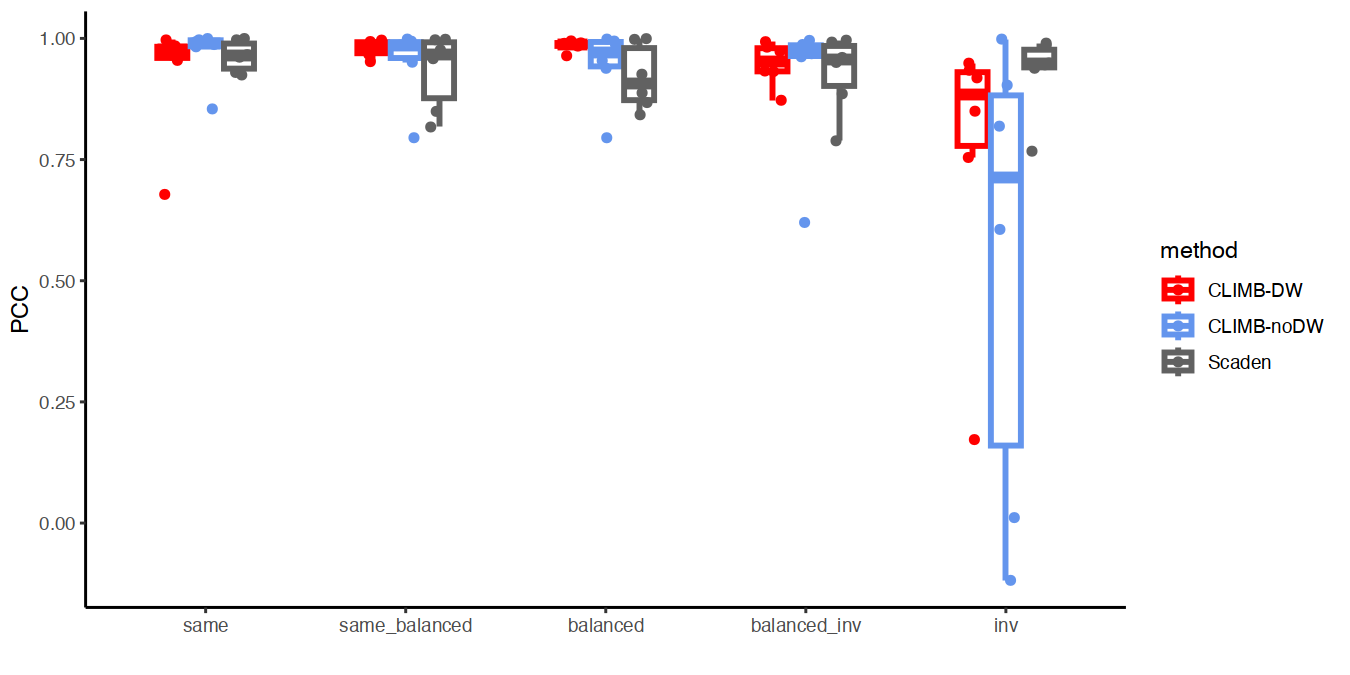

In [287]:
options(repr.plot.width=9, repr.plot.height=4.5, repr.plot.res=150)
g<- ggplot(df_melt_, aes(x=condition, y=PCC, color=method)) + geom_boxplot(size=1, width=0.5, outlier.shape = NA) + 
    geom_point(position=position_jitterdodge(jitter.width = 0.1,jitter.height = 0,dodge.width = 0.5)) + 
    theme_classic() +
    scale_color_manual(values=c('red', 'cornflowerblue', 'grey38')) + xlab('') + ylab('PCC')
pdf('/Users/acoudray/Desktop/tmp_samba/phd/main/pub_in_prep_figures_NatCommunication/REVISION_2/results/fig2/bias_boxplot_5conditions_climb_scaden.pdf', width=9, height=4.5) ; g ; dev.off()
g

In [290]:
list_ratio = list(ratio_cells_to_keep, ratio_cells_to_keep_50, ratio_cells_to_keep_balanced, ratio_cells_to_keep_inv_50, ratio_cells_to_keep_inv)
saveRDS(list_ratio, 'results/fig2/temp.RDS')

Of note: the sampling change by changing set.seed() which produces slightly different results at each run, but the overall outcome stays consistent

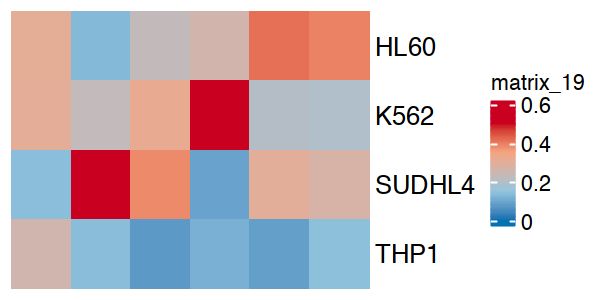

In [320]:
cell_numbers = as.vector(table(sc.es$cellType)) * do.call(rbind,ratio_inv)
cell_ratio_inv = cell_numbers / rowSums(cell_numbers)
col_fun = colorRamp2(c(0, 0.15, 0.35, 0.5), rev(brewer.pal(4,"RdBu"))) # we use the same color breaks for both heatmap
h_same <- Heatmap(t(cell_ratio_inv), col=col_fun, cluster_rows = F, cluster_columns = F, show_row_dend = F,
                  show_column_dend = F)
options(repr.plot.width=4, repr.plot.height=2, repr.plot.res=150)
#pdf('results/fig2/bias_sim_heatmap_all_same.pdf', width=4, height=4.5) ; h_same ; dev.off()
h_same

In [321]:
cor(flatten(cell_ratio_inv), flatten(true_prop))

[1] -0.811974

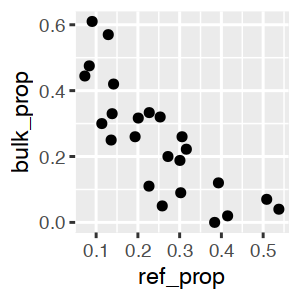

In [319]:
options(repr.plot.width=2, repr.plot.height=2, repr.plot.res=150)
cell_numbers = as.vector(table(sc.es$cellType)) * do.call(rbind,ratio_inv)
cell_ratio_inv = cell_numbers / rowSums(cell_numbers)
g <- ggplot(data.frame(ref_prop=flatten(cell_ratio_inv), bulk_prop=flatten(true_prop)), aes(x=ref_prop,y=bulk_prop)) + 
    geom_point() 
#pdf('bias_sim_heatmap_all_inv_dotplot.pdf', width=2, height=2) ; g ; dev.off()
g

No id variables; using all as measure variables



pdf 
  2

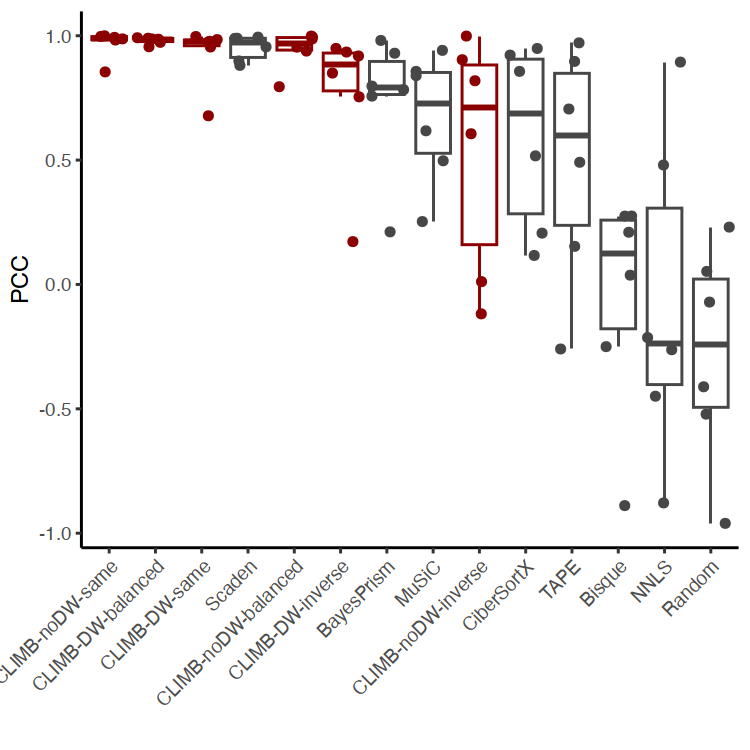

In [309]:
type.err=1
type.err.l = list('PCC', 'SCC', 'R2', 'RMSE')
methods = c('MuSiC', 'NNLS', 'CLIMB-DW-balanced', 'CLIMB-DW-same', 'CLIMB-DW-inverse', 'CLIMB-noDW-balanced', 'CLIMB-noDW-same', 
            'CLIMB-noDW-inverse', 'TAPE', 'Scaden', 'Bisque', 'Random', 'BayesPrism', 'CiberSortX')
df_scor = data.frame(cbind(all_res$MuSiC[[type.err]], all_res$NNLS[[type.err]], 
                           all_res$CLIMB[[type.err]], num(new_climb_match_same), num(new_climb_match_inv), 
                           num(climb_match_bal), num(climb_match_same), num(climb_match_inv), 
                           all_res$TAPE[[type.err]], all_res$Scaden[[type.err]],
                           all_res$BisqueRNA[[type.err]], all_res$Random[[type.err]], 
                           all_res$BayesPrism[[type.err]], all_res$CiberSortX[[type.err]]))
colnames(df_scor) = methods
levels_ = colnames(df_scor)[rev(order(colMedians(as.matrix(df_scor), na.rm = T)))]
df_scor_m = reshape2::melt(df_scor)
df_scor_m$variable = factor(df_scor_m$variable, levels = levels_) 
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=150)
g_rows = ggplot(df_scor_m) + geom_boxplot(aes(x=variable, y=value, color=variable), outlier.shape = NA) + theme_classic() +
            geom_jitter(aes(x=variable, y=value, color=variable)) + theme_classic() +
            scale_color_manual(values=ifelse(grepl('CLIMB',levels_), 'darkred', 'grey28')) + 
            theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
            xlab('') + ylab(type.err.l[type.err]) #+ coord_flip() # ylab(expression(pa
pdf('results/fig2/comparative_boxplots_imbalance_DW_weights.pdf', width=4, height=4.5) ; g_rows ; dev.off()
g_rows